# Analyze 2021 Citibike Data Anomalies
Gender and "user type" distributions in February+March 2021 Citibike data are way out of line with historical averages; [skip to plots at the end](#gender).

In [1]:
from boto3 import client
from datetime import datetime as dt
import pandas as pd
from tempfile import TemporaryDirectory
from zipfile import ZipFile

Public Citibike data is published to the `tripdata` Amazon S3 bucket:

In [2]:
s3 = client('s3')
bucket = 'tripdata'

We'll look at 2020 and 2021 data:

In [3]:
start = (2020, 1)
end = (2021, 3)

In [4]:
months = pd.date_range(*[ pd.to_datetime('%d-%02d' % (y, m)) for y,m in [start, end]], freq='MS').to_series()

Download one {month,region}'s data, tag it with {year,month,region}:

In [7]:
def load_csv(date, jc=False):
    y, m = date.year, date.month
    if jc:
        base = 'JC-'
    else:
        base = ''
    base += '%d%02d-citibike-tripdata' % (y, m)
    zip_key = f'{base}.csv.zip'
    with TemporaryDirectory() as d:
            zip_path = f'{d}/{base}.zip'
            s3.download_file(bucket, zip_key, zip_path)
            z = ZipFile(zip_path)
            names = z.namelist()
            print(f'{zip_key} contains names: {names}')
            [ name ] = [ f for f in names if f.endswith('.csv') and not f.startswith('_') ]
            with z.open(name,'r') as i:
                df = pd.read_csv(i)
                df = df[['gender','usertype']]
                df['year'] = y
                df['month'] = m
                if jc:
                    df['region'] = 'JC'
                else:
                    df['region'] = 'NYC'
                return df

Download + Concatenate all applicable months' data:

In [8]:
df = pd.concat([
    load_csv(month, jc=jc)
    for month in months.tolist()
    for jc in [False,True]
])
df

202012-citibike-tripdata.csv.zip contains names: ['202012-citibike-tripdata.csv']
JC-202012-citibike-tripdata.csv.zip contains names: ['JC-202012-citibike-tripdata.csv']
202101-citibike-tripdata.csv.zip contains names: ['202101-citibike-tripdata.csv']
JC-202101-citibike-tripdata.csv.zip contains names: ['JC-202101-citibike-tripdata.csv']
202102-citibike-tripdata.csv.zip contains names: ['202102-citibike-tripdata.csv']
JC-202102-citibike-tripdata.csv.zip contains names: ['JC-202102-citibike-tripdata.csv', '__MACOSX/._JC-202102-citibike-tripdata.csv']
202103-citibike-tripdata.csv.zip contains names: ['202103-citibike-tripdata.csv', '__MACOSX/._202103-citibike-tripdata.csv']
JC-202103-citibike-tripdata.csv.zip contains names: ['JC-202103-citibike-tripdata.csv', '__MACOSX/._JC-202103-citibike-tripdata.csv']


,gender,usertype,year,month,region
0,2,Customer,2020,12,NYC
1,1,Subscriber,2020,12,NYC
2,2,Subscriber,2020,12,NYC
3,0,Subscriber,2020,12,NYC
4,1,Customer,2020,12,NYC
...,...,...,...,...,...
16838,0,Customer,2021,3,JC
16839,0,Customer,2021,3,JC
16840,0,Customer,2021,3,JC
16841,0,Customer,2021,3,JC


Map 0, 1, 2 "gender" values to "U" (unspecified), "M" (male), and "F" (female):

In [9]:
df['gender'] = df['gender'].apply(lambda g: 'UMF'[int(g)])

Build count and percentage tables:

In [10]:
def column_hist(df, k, region=False):
    idx_keys = ['year','month']
    if region:
        idx_keys += ['region']
    all_keys = idx_keys + [k]
    counts = df[all_keys].value_counts().rename('count')
    counts = counts.reset_index().sort_values(all_keys).set_index(idx_keys)
    hist = counts.pivot_table(values='count', index=counts.index, columns=k, aggfunc='sum')
    hist = hist.set_index(pd.MultiIndex.from_tuples(hist.index))
    total = hist.sum(axis=1)
    for c in hist.columns:
        hist[f'{c}%'] = round(hist[c] / total * 100, 1)
    counts['date'] = counts.index.to_frame().apply(lambda r: pd.to_datetime('%d-%02d' % (r['year'], r['month'])), axis=1)
    return counts, hist

## Counts, Percentages <a id="counts"></a>

In [11]:
gc, gh = column_hist(df, 'gender')
uc, uh = column_hist(df, 'usertype')
hist = pd.concat([gh, uh], axis=1)
hist

F       M        U    F%    M%    U%  Customer  Subscriber  \
2020 12  293184  711540    95899  26.6  64.6   8.7    170602      930021   
2021 1   292460  722418    92092  26.4  65.3   8.3    152153      954817   
     2    46415  125890   467051   7.3  19.7  73.1    472083      167273   
     3    59984  129357  1321559   4.0   8.6  87.5   1331580      179320   

         Customer%  Subscriber%  
2020 12       15.5         84.5  
2021 1        13.7         86.3  
     2        73.8         26.2  
     3        88.1         11.9

In [12]:
gc

gender    count       date
year month                           
2020 12         F   293184 2020-12-01
     12         M   711540 2020-12-01
     12         U    95899 2020-12-01
2021 1          F   292460 2021-01-01
     1          M   722418 2021-01-01
     1          U    92092 2021-01-01
     2          F    46415 2021-02-01
     2          M   125890 2021-02-01
     2          U   467051 2021-02-01
     3          F    59984 2021-03-01
     3          M   129357 2021-03-01
     3          U  1321559 2021-03-01

In [13]:
uc

usertype    count       date
year month                                
2020 12       Customer   170602 2020-12-01
     12     Subscriber   930021 2020-12-01
2021 1        Customer   152153 2021-01-01
     1      Subscriber   954817 2021-01-01
     2        Customer   472083 2021-02-01
     2      Subscriber   167273 2021-02-01
     3        Customer  1331580 2021-03-01
     3      Subscriber   179320 2021-03-01

In [14]:
import plotly.express as px

## Gender breakdown <a id="gender"></a>

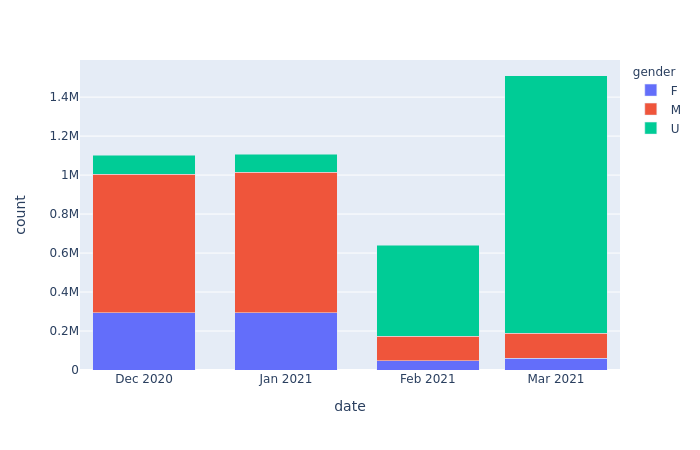

In [15]:
px.bar(
    gc,
    x='date',
    y='count',
    color='gender',
    barmode='stack',
).show(renderer='png')

## "User type" plot <a id="usertype"></a>

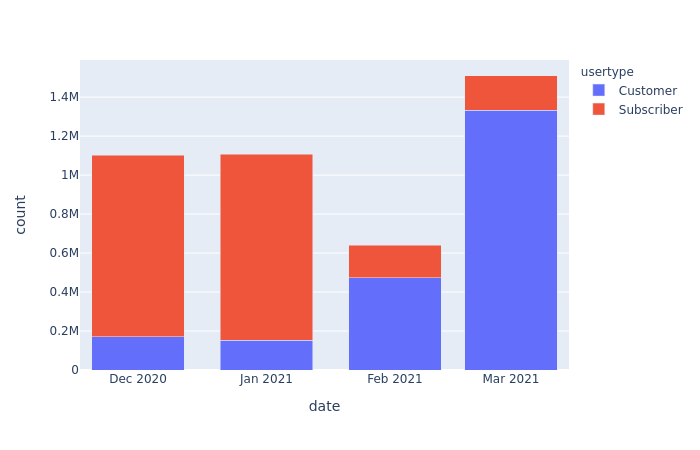

In [16]:
px.bar(
    uc,
    x='date',
    y='count',
    color='usertype',
    barmode='stack',
).show(renderer='png')